In [147]:
# Initial Imports
import pandas as pd
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy
import matplotlib.pyplot as plt

In [2]:
# Read in lyrics data
lyrics = pd.read_csv("data/songdata.csv")

In [3]:
# Required columns
cols=['song', 'artist', 'trackid', 'danceability', 'energy', 'key', 'mode', 
      'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
      'valence', 'tempo', 'duration_ms', 'time_signature',
     'duration', 'analysis_sample_rate', 'analysis_channels', 
      'end_of_fade_in', 'start_of_fade_out', 'loudness', 'tempo', 'tempo_confidence', 
      'time_signature', 'time_signature_confidence', 'key', 'key_confidence', 'mode', 'mode_confidence']

In [4]:
cols = list(np.unique(cols))

In [5]:
# Creating dataframe for audio features
features=pd.DataFrame(columns=cols)

In [6]:
artists = ['Eminem', 'Passenger', 'Bruno Mars', 'Coldplay', 'Ozzy Osbourne', 'Slayer','Metallica','Beatles','Dire Straits' ,'Radiohead', 'Taylor Swift', 'Aerosmith','Ed Sheeran', 'Drake', 'Pink Floyd', 'Queen', 'Billy Joel', 'Iron Maiden', 'Black Sabbath','Green Day' ]

In [7]:
songs = ['Let It Be', 'Let Her Go','Hey Jude', '', 'Marry You','Yellow', 'The Lazy Song','Norwegian Wood', 'Wonderful Tonight',  'Imagine', 'I Knew You Were Trouble', 'Love Story', 'A Team', 'Sing', 'Bohemian Rhapsody', 'Electric Funeral', 'Valhalla', 'American Idiot', 'Angel Of Death', 'War Pigs', 'The Trooper']

In [8]:
# Filtering on artist
lyrics = lyrics[lyrics.artist.isin(artists)]
# Select songs based on the list of songs or a list of artists or both
songs_selected = lyrics[lyrics.song.isin(songs)]

In [9]:
songs_selected.shape

(16, 4)

In [10]:
# sample dataframe is used for all analysis here on
sample = songs_selected
sample.reset_index(inplace=True)

In [11]:
list(sample['song'])

['Electric Funeral',
 'Marry You',
 'The Lazy Song',
 'Yellow',
 'Wonderful Tonight',
 'American Idiot',
 'War Pigs',
 'Let Her Go',
 'Angel Of Death',
 'I Knew You Were Trouble',
 'Love Story',
 'Valhalla',
 'A Team',
 'Sing',
 'The Trooper',
 'Bohemian Rhapsody']

In [12]:
# Get audio features for the songs in the sample dataframe
# Client Credentials
client_id = "5fc0da4106eb48e1913868f4950828fb"
client_secret = "5a549bc4674e47dfaf3b06da4500a44d"

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

for index,row in sample.iterrows():
    song = row['song']
    
    temp = pd.DataFrame(columns = cols)
    temp['song'] = [song]
    temp['artist'] = [row['artist']]
    
    try:
        result = sp.search(song, type='track', limit=1)

    except:
        print('SOme error')
        continue
        
    if len(result['tracks']['items']) == 0:
        continue
    
    trackid=result['tracks']['items'][0]['id']
    temp['trackid'] = [trackid]
    
    try:
        feat=sp.audio_features(trackid)[0]
        analysis=sp.audio_analysis(trackid)['track']
    except error as e:
        print(e)
        continue
    
    combined = {**feat, **analysis}
    
    for col in cols:
        if col in ['song', 'artist', 'trackid']:
            continue
        temp[col]= combined[col]
        
    features = features.append(temp, ignore_index=True)

In [13]:
features = features.T.drop_duplicates().T

In [14]:
# Getting word vectors
import nltk
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer

# Getting all text for training own word vectors
all_text = ' '.join(lyrics.text)
all_text = all_text.replace('\n', '')
sent_text = nltk.sent_tokenize(all_text)

[nltk_data] Downloading package punkt to /home/aman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
# Training and saving the word vec model
wv_dimension = 20

tokenizer = RegexpTokenizer(r'\w+').tokenize

sent_tokenized = []
for sent in sent_text:
    sent_tokenized.append(tokenizer(sent))
    
from gensim.models import Word2Vec
from gensim.test.utils import common_texts, get_tmpfile

path = get_tmpfile("word2vec.model")
model = Word2Vec(sent_tokenized, size=wv_dimension, window=5, min_count=3, workers=4)

model.save("word2vec.model")

In [16]:
# Finding wv representation for the lyrics in the dataframe sample
# Creating a dataframe wv with the word vectors
wv = []
for lyr in sample.text:
    vec = [0] * wv_dimension
    c = 0
    words = tokenizer(lyr)
    for word in words:
        try:
            vec = vec + model[word]
            c = c + 1
        except:
            vec = vec + [0] * wv_dimension
    vec = np.array(vec) / c
    wv.append(vec)

/home/aman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
/home/aman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


In [17]:
# Naimg the columns in wv to 1-wv_dimension
req_cols = list(range(wv_dimension))
wv_df = pd.DataFrame(wv)[req_cols]
wv_df['song'] = sample['song']

In [18]:
# wv_df.to_csv('word_vectors_songs.csv', index=None)

In [19]:
# Making a copy for preservation
features_copy = features.copy()

In [20]:
# Merging features and wv to get dataframe with audio features and the word vectors
df_all = pd.merge(features, wv_df, how='left', on='song')
# Removing empty rows
df_all = df_all[df_all['trackid'] != 'NA']

In [21]:
# Drop rows with NA values
df_all = df_all.dropna()

In [22]:
df_all.reset_index(inplace=True, drop=True)

In [23]:
# Get a list of column in the consolidated dataframe
cols = list(df_all.columns)

In [24]:
# Remove columns not required for clustering
cols.remove('song')
cols.remove('artist')
cols.remove('trackid')

In [25]:
df_all.shape

(14, 45)

In [26]:
# Scaling the dataframe 
from sklearn import preprocessing

x = df_all[cols].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

# Adding song and artist to the scaled dataframe
df.columns = cols
df['song'] = df_all['song']
df['artist'] = df_all['artist']

/home/aman/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [27]:
# Removing unnecessary columns from the list of columns for clustering
dfcols = list(df.columns)
dfcols.remove('song')
dfcols.remove('artist')

In [28]:
# Perform Kmeans on the consolidated scaled dataset
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(df[dfcols])
df['label'] = kmeans.labels_

In [29]:
df.label.unique()

array([0, 2, 1])

In [30]:
df[df.label==1]

,acousticness,analysis_channels,analysis_sample_rate,danceability,duration,duration_ms,end_of_fade_in,energy,instrumentalness,key,...,13,14,15,16,17,18,19,song,artist,label
4,0.000000,0.0,0.0,0.144201,0.000000,0.000000,1.000000,0.989770,0.000609,0.0,...,0.561245,0.255230,0.045895,0.406921,0.299055,0.111200,0.196880,American Idiot,Green Day,1
5,0.331812,0.0,0.0,0.068966,1.000000,1.000000,0.000000,0.523018,0.006845,0.8,...,0.992099,0.772784,0.486932,0.430892,0.456309,0.272603,0.000000,War Pigs,Ozzy Osbourne,1
9,0.000090,0.0,0.0,0.319749,0.404681,0.404682,0.000000,1.000000,0.000000,0.5,...,0.619852,0.405055,0.000000,0.498926,0.000000,0.898921,0.075792,Valhalla,Black Sabbath,1
12,0.025672,0.0,0.0,0.000000,0.250325,0.250327,0.100595,0.831202,0.439535,0.3,...,0.334923,0.638531,0.209348,0.501837,0.413908,0.874821,0.269387,The Trooper,Iron Maiden,1


In [31]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
cluster.fit_predict(df[dfcols])

df.label=cluster.labels_

In [32]:
df[df.label==1]

,acousticness,analysis_channels,analysis_sample_rate,danceability,duration,duration_ms,end_of_fade_in,energy,instrumentalness,key,...,13,14,15,16,17,18,19,song,artist,label
4,0.000000,0.0,0.0,0.144201,0.000000,0.000000,1.000000,0.989770,0.000609,0.0,...,0.561245,0.255230,0.045895,0.406921,0.299055,0.111200,0.196880,American Idiot,Green Day,1
5,0.331812,0.0,0.0,0.068966,1.000000,1.000000,0.000000,0.523018,0.006845,0.8,...,0.992099,0.772784,0.486932,0.430892,0.456309,0.272603,0.000000,War Pigs,Ozzy Osbourne,1
9,0.000090,0.0,0.0,0.319749,0.404681,0.404682,0.000000,1.000000,0.000000,0.5,...,0.619852,0.405055,0.000000,0.498926,0.000000,0.898921,0.075792,Valhalla,Black Sabbath,1
12,0.025672,0.0,0.0,0.000000,0.250325,0.250327,0.100595,0.831202,0.439535,0.3,...,0.334923,0.638531,0.209348,0.501837,0.413908,0.874821,0.269387,The Trooper,Iron Maiden,1


In [33]:
# Getting sentiment for the sample
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sentiment_data = pd.DataFrame(columns=['positive', 'negative', 'neutral', 'compound', 'song'])
for index, row in sample.iterrows():
    pos = []
    neg = []
    neu = []
    compound = []
    sentences=nltk.sent_tokenize(row.text)
    analyzer = SentimentIntensityAnalyzer()
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        pos.append(vs['pos'])
        neg.append(vs['neg'])
        neu.append(vs['neu'])
        compound.append(vs['compound'])
    tmp = pd.DataFrame([[np.average(pos), np.average(neg), np.average(neu), np.average(compound), row['song']]], columns=['positive', 'negative', 'neutral', 'compound', 'song'])
    sentiment_data = pd.concat([sentiment_data, tmp], ignore_index=True)

In [113]:
# Merge the dataset to add sentiment calues
df_with_sentiment = pd.merge(df_all, sentiment_data, how='left', on='song')

In [122]:
# Scaling the dataframe
x = df_with_sentiment[dfcols + ['positive', 'negative', 'neutral', 'compound']].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_with_sentiment = pd.DataFrame(x_scaled, columns=dfcols + ['positive', 'negative', 'neutral', 'compound'])
df_with_sentiment['song'] = df_all['song']
df_with_sentiment['artist'] = df_all['artist']

/home/aman/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [123]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
cluster.fit_predict(df_with_sentiment[dfcols + ['positive', 'negative', 'neutral', 'compound']])

df_with_sentiment.label=cluster.labels_

/home/aman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [124]:
list(df_with_sentiment[df_with_sentiment.label==2]['song'])

['Marry You', 'The Lazy Song', 'Yellow', 'Sing', 'Bohemian Rhapsody']

In [134]:
# Perform Kmeans on the consolidated scaled dataset
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000).fit(df_with_sentiment[dfcols + ['positive', 'negative', 'neutral', 'compound']])
df_with_sentiment['label'] = kmeans.labels_

In [135]:
df_with_sentiment[df_with_sentiment.label==1]

,acousticness,analysis_channels,analysis_sample_rate,danceability,duration,duration_ms,end_of_fade_in,energy,instrumentalness,key,...,17,18,19,positive,negative,neutral,compound,song,artist,label
4,0.000000,0.0,0.0,0.144201,0.000000,0.000000,1.000000,0.989770,0.000609,0.0,...,0.299055,0.111200,0.196880,0.328872,0.534462,0.249720,0.460676,American Idiot,Green Day,0
5,0.331812,0.0,0.0,0.068966,1.000000,1.000000,0.000000,0.523018,0.006845,0.8,...,0.456309,0.272603,0.000000,0.055762,0.593846,0.464995,0.008112,War Pigs,Ozzy Osbourne,0
9,0.000090,0.0,0.0,0.319749,0.404681,0.404682,0.000000,1.000000,0.000000,0.5,...,0.000000,0.898921,0.075792,0.579926,0.436923,0.107307,0.776927,Valhalla,Black Sabbath,0
12,0.025672,0.0,0.0,0.000000,0.250325,0.250327,0.100595,0.831202,0.439535,0.3,...,0.413908,0.874821,0.269387,0.204461,0.612308,0.282177,0.008963,The Trooper,Iron Maiden,0


In [145]:
# Plotting silhouette score for assesing the relative goodness of clusters
from sklearn.metrics import silhouette_score

scores = []
for num_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0, max_iter=1000).fit(df_with_sentiment[dfcols + ['positive', 'negative', 'neutral', 'compound']])
    scores.append(silhouette_score(df_with_sentiment[dfcols + ['positive', 'negative', 'neutral', 'compound']], kmeans.labels_))

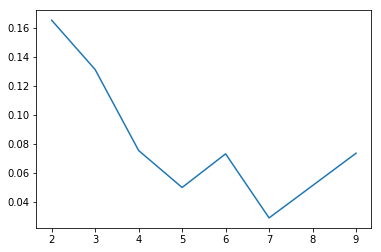

In [148]:
plt.plot(range(2, 10), scores)

In [169]:
# Calculating Dunn Index
req_cols = dfcols + ['positive', 'negative', 'neutral', 'compound'] + ['label']
# Function to calculate eucledian distance
def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)

def cal_intra_clstr_max_dist(df):
    max_dist = 0
    df = df[req_cols]
    for label in df['label']:
        d = df[df['label'] == label]
        ct = list(d.columns)
        ct.remove('label')
        dv = d[ct].values
        for X in dv:
            distance = np.max(dist(X, dv))
            if distance > max_dist:
                max_dist = distance
    
    return max_dist

def cal_ceteroid_dist(centeroids):
    max_dist = 0
    
    for c in centeroids:
        dis = np.delete(dist(c, centeroids), np.where(dist(c, centeroids) == 0))
        distance = np.min(dis)
        if distance > max_dist:
            max_dist = distance
    
    return max_dist

def cal_dunn_index(df, centeroids):
    return cal_ceteroid_dist(centeroids) / cal_intra_clstr_max_dist(df)

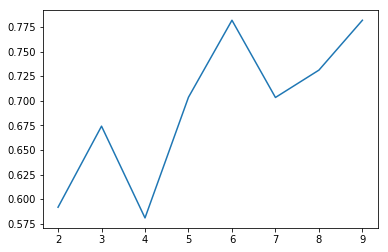

In [171]:
scores = []
for num_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0, max_iter=1000).fit(df_with_sentiment[dfcols + ['positive', 'negative', 'neutral', 'compound']])
    scores.append(cal_dunn_index(df_with_sentiment, kmeans.cluster_centers_))

plt.plot(range(2, 10), scores)

In [152]:
df_with_sentiment.values[0]

array([0.496243200030614, 0.0, 0.0, 0.5203761755485893,
       0.1804402237845456, 0.18044118732676995, 0.03720730323556717,
       0.7902813299232736, 0.0, 0.9, 0.28088578088578087,
       0.12248995983935741, 0.7934182433924759, 1.0, 0.380281690140845,
       0.04303147077713551, 0.16331449466384695, 0.6296665947345704,
       0.7269279393173199, 0.0, 0.6459627329192545, 0.46287157121542527,
       0.5031343820780323, 0.0, 0.22810197881783897, 0.0,
       0.34619054518719916, 1.0, 0.030047013386085286, 0.709099143853654,
       0.25974357231930156, 1.0, 0.8608349210696451, 0.9663295658062678,
       0.11932447620345354, 0.5600018773016888, 0.0, 0.47573342875827623,
       0.4329051667446955, 0.5524355498839602, 0.3456127445501865,
       0.4094194080875422, 1.0000000000000002, 0.061538461538461535,
       0.13910119229593354, 1.0, 'Marry You', 'Bruno Mars', 1],
      dtype=object)

['acousticness',
 'analysis_channels',
 'analysis_sample_rate',
 'danceability',
 'duration',
 'duration_ms',
 'end_of_fade_in',
 'energy',
 'instrumentalness',
 'key',
 'key_confidence',
 'liveness',
 'loudness',
 'mode',
 'mode_confidence',
 'speechiness',
 'start_of_fade_out',
 'tempo',
 'tempo_confidence',
 'time_signature',
 'time_signature_confidence',
 'valence',
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 'positive',
 'negative',
 'neutral',
 'compound']

In [165]:
a = np.array([0, 1, 2, 0, 0, 1, 0])

In [166]:
np.where(a == 0)

(array([0, 3, 4, 6]),)